In [ ]:
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#   Statistical Methods - Assignment II: fMRI Decoding Project Code
#   Author: Bati Yilmaz
#   July - August 2021
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#   The Project Pipeline:
#   1.  Download subjects 1-4 of the Haxby data (datasets.fetch haxby() from nilearn) done
#   2.  Subset the data to include all available classes, except rest. done
#   3.  Perform suitable data pre processing, including at least run-wise detrending and standardisation done
#   4.  Using the preprocessed data, set up a leave-one-run-out multi-class classification scheme. done
#   5.  a)Compare performance of a multinomial logistic regression with a linear SVM either using one-vs-rest or a one-vs-one multi class classification.
#   6.  Make a graph that shows the mean decoding accuracy for each approach and the variability between subjects.
#   7.  b)Report the decoding accuracy (percent true positives) for the individual classes and make a corresponding figure. Can some classes be decoded better than others?
#   8.  c)Using a linear SVM and the multi-class approach that worked best in a), set up a nested cross validation scheme in which you first find the best C parameter,
#   ...and then decode using that C.
#   9.  Submit your code of the nested cross validation (preferably using nilearn & sklearn)
#   10. Creating graphs that illustrate and describe the behavior of λEW(w) as a function of the two parameters and the weights (Problem 2)
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#########################
# PROJECT CODE
#########################

# Importing the necessary toolboxes
!pip install nilearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets
from nilearn import plotting, image, masking
from nilearn.image import mean_img
from sklearn import svm
from nilearn.input_data import NiftiMasker
from nilearn import plotting
# from utils import masking, signal
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier, RidgeClassifierCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from nilearn.plotting import plot_anat, show, plot_stat_map, plot_matrix
from sklearn.svm import SVC
from nilearn.image import index_img
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from nilearn import datasets
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectPercentile, f_classif, SelectKBest
from nilearn.decoding import Decoder
import nibabel as nib
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from nilearn.plotting import plot_matrix, show
from sklearn.model_selection import KFold
from google.colab import files

     |████████████████████████████████| 4.9 MB 7.2 MB/s 


/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [ ]:
# Downloading the subjects 1-4 of the Haxby dataset
haxby_dataset = datasets.fetch_haxby(subjects=[1, 2, 3, 4], fetch_stimuli=True)

# A brief dataset documentation
# print(haxby_dataset['description'].decode('utf-8'))


Dataset created in /root/nilearn_data/haxby2001



 ...done. (0 seconds, 0 min)
 ...done. (0 seconds, 0 min)


Downloaded 302178304 of 314803244 bytes (96.0%,    0.4s remaining) ...done. (10 seconds, 0 min)
Extracting data from /root/nilearn_data/haxby2001/570d0f0e6c7d7f94134c45241f118313/subj1-2010.01.14.tar.gz..... done.


Downloaded 262086656 of 291168628 bytes (90.0%,    0.9s remaining) ...done. (9 seconds, 0 min)
Extracting data from /root/nilearn_data/haxby2001/570d0f0e6c7d7f94134c45241f118313/subj2-2010.01.14.tar.gz..... done.


Downloaded 284606464 of 296936090 bytes (95.8%,    0.4s remaining) ...done. (10 seconds, 0 min)
Extracting data from /root/nilearn_data/haxby2001/570d0f0e6c7d7f94134c45241f118313/subj3-2010.01.14.tar.gz..... done.


Downloaded 300531712 of 329954386 bytes (91.1%,    1.0s remaining) ...done. (11 seconds, 0 min)
Extracting data from /root/nilearn_data/haxby2001/570d0f0e6c7d7f94134c45241f118313/subj4-2010.01.14.tar.gz..... done.


 ...done. (1 seconds, 0 min)
Extracting data from /root/nilearn_data/haxby2001/0a25a08cd199b76ff7f6fe9a2d8710e7/stimuli-2010.01.14.tar.gz..... done.


In [ ]:
# A big for loop through 4 subjects
accuracies_mnlr = []
accuracies_svm_ovr = []
accuracies_svm_ovo = []

conf_mat_mnlr = np.zeros([8, 8])
conf_mat_svm_ovr = np.zeros([8, 8])
conf_mat_svm_ovo = np.zeros([8, 8])

for subs in range(4):
  haxby_path = haxby_dataset.func[subs]
  behavioral = pd.read_csv(haxby_dataset.session_target[subs], sep=" ")
  runs_all = behavioral['chunks'].values
  conditions_all = behavioral['labels'].values
  nruns = len(np.unique(runs_all))


# selecting the 8 individual categories
# condition_idx = behavioral['labels'].isin(['bottle', 'cat', 'chair', 'face', 'house', 'scissors', 'scrambledpix','shoe'])
  condition_idx = -behavioral['labels'].isin(['rest'])
  runs = runs_all[condition_idx]
  conditions = conditions_all[condition_idx]

  nifti_masker = NiftiMasker(standardize=True, runs=runs_all, detrend=True,
                mask_strategy='epi', smoothing_fwhm=4, high_pass=1/128, t_r=2.5)

    #subject_mask_vt = haxby_dataset.mask_vt[subs]
    #subject_mask_face = haxby_dataset.mask_face[subs]
    #subject_mask_house = haxby_dataset.mask_house[subs]
  
  #mean_epi = image.mean_img(haxby_path)
  #plotting.plot_epi(mean_epi)

# EPI whole brain mask
  #mask_epi = masking.compute_epi_mask(haxby_path)
  #plotting.plot_roi(mask_epi, mean_epi)

  #a different mask (ventral temporal mask)
  #ask_vt = image.load_img(haxby_dataset.mask_vt[subs])
  #plotting.plot_roi(mask_vt, mean_epi)
  
  # fmri_masked = masking.apply_mask(haxby_path, mask_epi)
  nifti_masker.fit(haxby_path)
  mask_img = nifti_masker.mask_img_
  fmri_masked = nifti_masker.transform(haxby_path)

  cdata = fmri_masked[np.where(condition_idx)[0], :]

  clf = make_pipeline(StandardScaler(), LogisticRegression(C=1., penalty='l2',
                    multi_class='multinomial', max_iter=5000, class_weight='balanced'))
  fold_acc_mnlr = np.empty([nruns])
  fold_acc_svm_ovr = np.empty([nruns])
  fold_acc_svm_ovo = np.empty([nruns])

  for cfold in range(0, nruns):
    test_data = cdata[np.where(runs == cfold)[0], :]
    test_labels = conditions[np.where(runs == cfold)[0]]
    train_data = cdata[np.where(runs != cfold)[0], :]
    train_labels = conditions[np.where(runs != cfold)[0]]

    cclf = clf.fit(train_data, train_labels)
  # Linear Support Vector Machine (SVM) using both one-vs-rest and one-vs-one strategies
    svm_ovr = OneVsRestClassifier(LinearSVC(C=1., penalty ='l2', class_weight = 'balanced', max_iter=5000), n_jobs = -1).fit(train_data, train_labels)
    svm_ovo = OneVsOneClassifier(LinearSVC(C=1., penalty ='l2', class_weight = 'balanced', max_iter=5000), n_jobs = -1).fit(train_data, train_labels)

    conf_mat_mnlr = conf_mat_mnlr + confusion_matrix(test_labels, cclf.predict(test_data))
    conf_mat_svm_ovr = conf_mat_svm_ovr + confusion_matrix(test_labels, svm_ovr.predict(test_data))
    conf_mat_svm_ovo = conf_mat_svm_ovo + confusion_matrix(test_labels, svm_ovo.predict(test_data))

    fold_acc_mnlr[cfold] = cclf.score(test_data, test_labels)
    fold_acc_svm_ovr[cfold] = svm_ovr.score(test_data, test_labels)
    fold_acc_svm_ovo[cfold] = svm_ovo.score(test_data, test_labels)
    print('Fold: {0:3d}'.format(cfold), end='')
    print(' | {0:6.2f}'.format(fold_acc_mnlr[cfold]*100), end='%')
    print(' | {0:6.2f}'.format(fold_acc_svm_ovr[cfold]*100), end='%')
    print(' | {0:6.2f}'.format(fold_acc_svm_ovo[cfold]*100), end='%')
    print(' | Done!')

  print('*****')
  print('Final Accuracy: {0:6.2f}'.format(np.mean(fold_acc_mnlr)*100), end='%')
  print('Final Accuracy: {0:6.2f}'.format(np.mean(fold_acc_svm_ovr)*100), end='%')
  print('Final Accuracy: {0:6.2f}'.format(np.mean(fold_acc_svm_ovo)*100), end='%')
  print('*****')

  # Cross Validation Accuracies
  accuracies_mnlr.append(np.mean(fold_acc_mnlr) * 100)
  accuracies_svm_ovr.append(np.mean(fold_acc_svm_ovr) * 100)
  accuracies_svm_ovo.append(np.mean(fold_acc_svm_ovo) * 100)

Fold:   0 |  54.17% |  58.33% |  47.22% | Done!
Fold:   1 |  59.72% |  58.33% |  50.00% | Done!
Fold:   2 |  52.78% |  51.39% |  50.00% | Done!
Fold:   3 |  59.72% |  65.28% |  40.28% | Done!
Fold:   4 |  62.50% |  70.83% |  45.83% | Done!
Fold:   5 |  66.67% |  70.83% |  56.94% | Done!
Fold:   6 |  55.56% |  58.33% |  47.22% | Done!
Fold:   7 |  54.17% |  55.56% |  47.22% | Done!
Fold:   8 |  68.06% |  69.44% |  58.33% | Done!
Fold:   9 |  72.22% |  69.44% |  56.94% | Done!
Fold:  10 |  52.78% |  54.17% |  47.22% | Done!
Fold:  11 |  62.50% |  61.11% |  55.56% | Done!
*****
Final Accuracy:  60.07%Final Accuracy:  61.92%Final Accuracy:  50.23%*****


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Fold:   0 |  33.33% |  34.72% |  27.78% | Done!
Fold:   1 |  43.06% |  40.28% |  38.89% | Done!
Fold:   2 |  59.72% |  58.33% |  51.39% | Done!
Fold:   3 |  33.33% |  40.28% |  23.61% | Done!
Fold:   4 |  58.33% |  58.33% |  50.00% | Done!
Fold:   5 |  59.72% |  62.50% |  50.00% | Done!
Fold:   6 |  51.39% |  54.17% |  47.22% | Done!
Fold:   7 |  56.94% |  61.11% |  43.06% | Done!
Fold:   8 |  44.44% |  52.78% |  33.33% | Done!
Fold:   9 |  54.17% |  56.94% |  50.00% | Done!
Fold:  10 |  58.33% |  63.89% |  45.83% | Done!
Fold:  11 |  48.61% |  55.56% |  30.56% | Done!
*****
Final Accuracy:  50.12%Final Accuracy:  53.24%Final Accuracy:  40.97%*****
Fold:   0 |  54.17% |  55.56% |  50.00% | Done!
Fold:   1 |  61.11% |  62.50% |  44.44% | Done!
Fold:   2 |  51.39% |  52.78% |  45.83% | Done!
Fold:   3 |  47.22% |  52.78% |  48.61% | Done!
Fold:   4 |  55.56% |  59.72% |  55.56% | Done!
Fold:   5 |  40.28% |  45.83% |  36.11% | Done!
Fold:   6 |  40.28% |  41.67% |  33.33% | Done!
Fold:  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

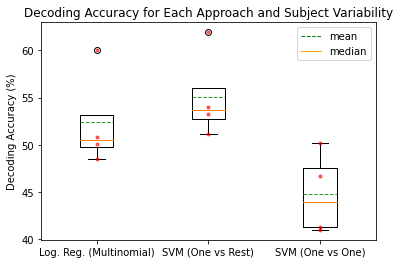

In [ ]:
# Choosing the best strategy and making a boxplot of group mean (model.score() accuracy) and each 4 subjects' individual mean (variability) 
group_decoding_average_mnlr = np.mean(accuracies_mnlr)
group_decoding_average_svm_ovr = np.mean(accuracies_svm_ovr)
group_decoding_average_svm_ovo = np.mean(accuracies_svm_ovo)

# Creating a boxplot for mean decoding accuracy and each 4 subjects' accuracy and three different classifiers
plt.boxplot(np.array([accuracies_mnlr, accuracies_svm_ovr, accuracies_svm_ovo]).T, meanline = True, showmeans=True)

plt.plot([], [], '--', linewidth=1, color='Green', label='mean')
plt.plot([], [], '-', linewidth=1, color='Orange', label='median')

plt.xticks([1, 2, 3], ['Log. Reg. (Multinomial)','SVM (One vs Rest)','SVM (One vs One)'])
plt.ylabel('Decoding Accuracy (%)')
plt.title('Decoding Accuracy for Each Approach and Subject Variability')    

plt.legend()

plt.plot([1, 1, 1, 1], accuracies_mnlr, 'r.', alpha = 0.6)          
plt.plot([2, 2, 2, 2], accuracies_svm_ovr, 'r.', alpha = 0.6)
plt.plot([3, 3, 3, 3], accuracies_svm_ovo, 'r.', alpha = 0.6)

plt.savefig("1a_results_prototype.png")
#image = plt.figure(figsize=(16,10), dpi= 200)
#image.savefig('1a_results_prototype.png')
files.download("1a_results_prototype.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

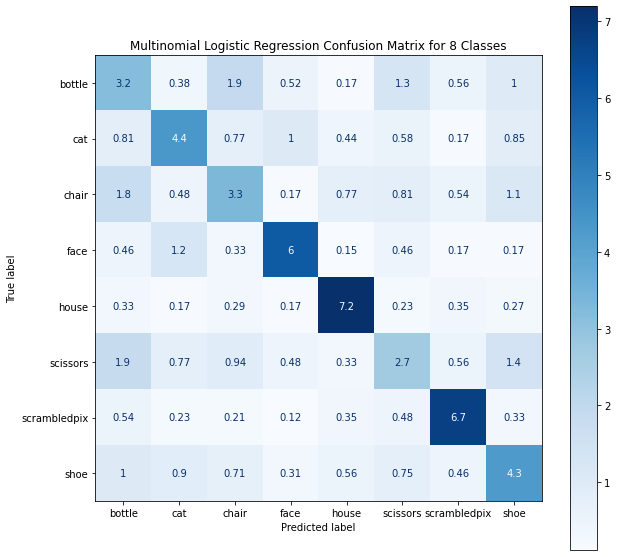

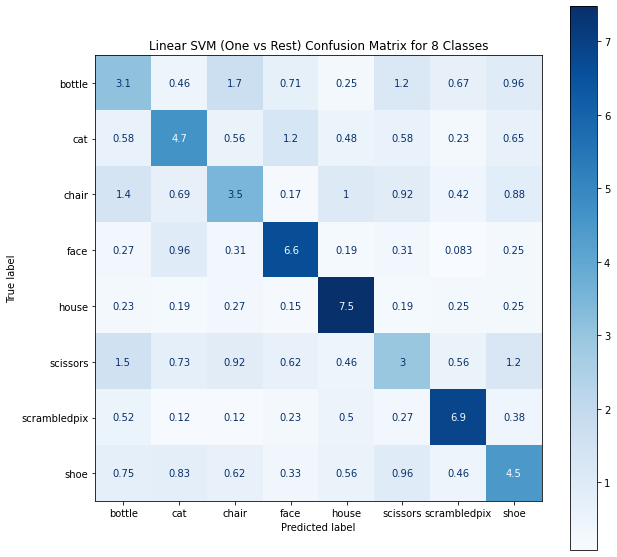

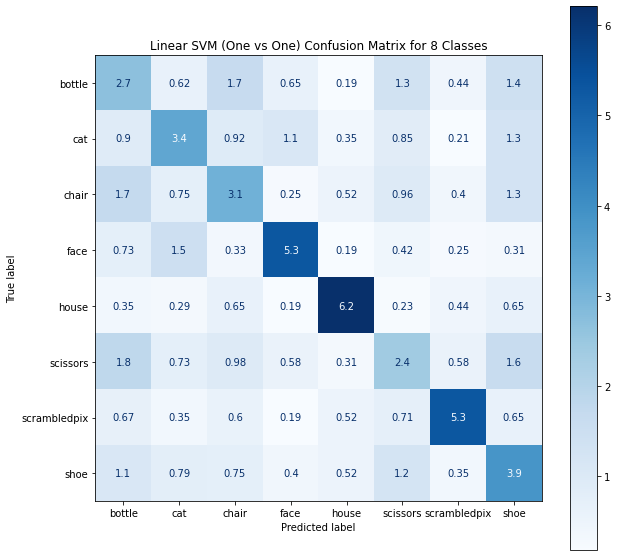

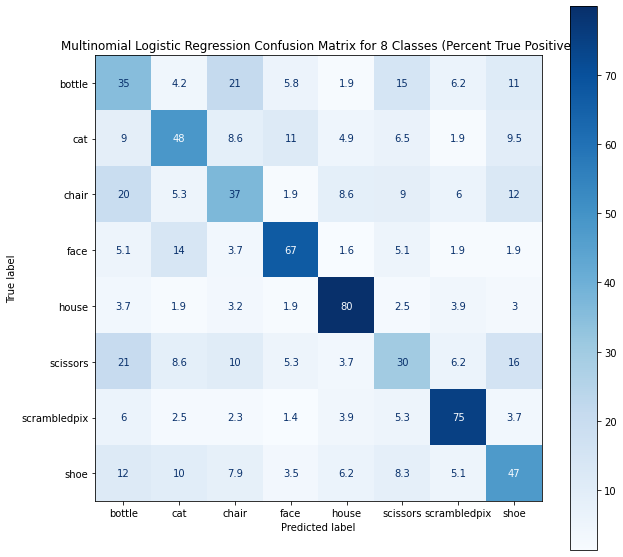

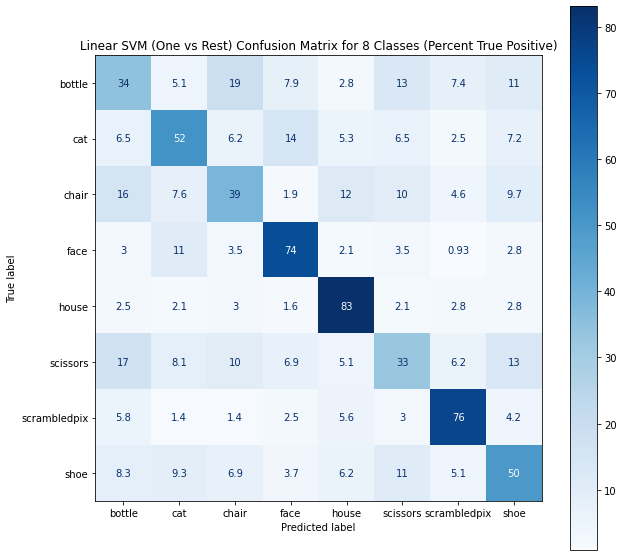

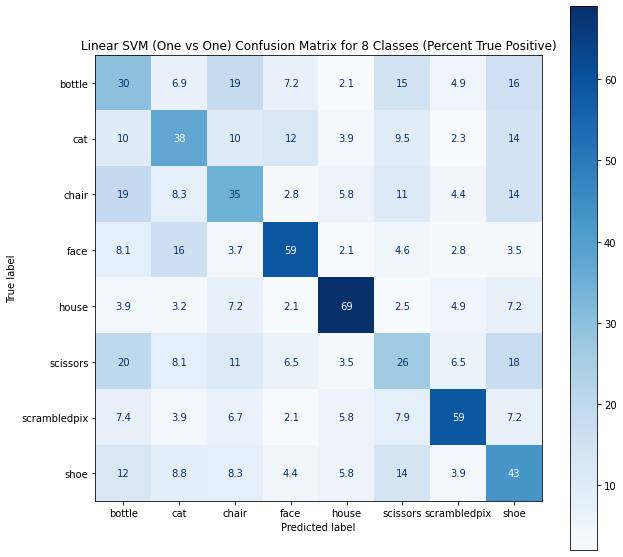

In [ ]:
# 1b) Subsetting the data to one class and using the recall score (model.predict())
# Reporting the decoding accuracy for the each 8 individual classes
# Creating confusion matrices
# ConfusionMatrixDisplay, confusion_matrix functions...

conditions_label = np.unique(conditions)

disp_mnlr_confusion = ConfusionMatrixDisplay(confusion_matrix = conf_mat_mnlr/nruns/4, display_labels = conditions_label)
fig, ax = plt.subplots(figsize=(10,10))
disp_mnlr_confusion.plot(ax=ax, cmap = 'Blues')
# cbar_mnrl_confusion = disp_mnlr_confusion.colorbar
plt.title('Multinomial Logistic Regression Confusion Matrix for 8 Classes')
#  cbar_mnlr_confusion.set_label('Number of Cases for One Run', rotation=270)
# 'Average True Positive Rate' for true positive matrices

plt.savefig("multinomial_log_reg_conf_mat.png")
files.download("multinomial_log_reg_conf_mat.png")

disp_svm_ovr_confusion = ConfusionMatrixDisplay(confusion_matrix = conf_mat_svm_ovr/nruns/4, display_labels = conditions_label)
fig, ax = plt.subplots(figsize=(10,10))
disp_svm_ovr_confusion.plot(ax=ax, cmap = 'Blues') 
plt.title('Linear SVM (One vs Rest) Confusion Matrix for 8 Classes')

plt.savefig("linear_svm_ovr_conf_mat.png")
files.download("linear_svm_ovr_conf_mat.png")

disp_svm_ovo_confusion = ConfusionMatrixDisplay(confusion_matrix = conf_mat_svm_ovo/nruns/4, display_labels = conditions_label)
fig, ax = plt.subplots(figsize=(10,10))
disp_svm_ovo_confusion.plot(ax=ax, cmap = 'Blues') 
plt.title('Linear SVM (One vs One) Confusion Matrix for 8 Classes')

plt.savefig("linear_svm_ovo_conf_mat.png")
files.download("linear_svm_ovo_conf_mat.png")

# Calculating Percent (or Rate) True Positives

disp_mnlr_confusion = ConfusionMatrixDisplay(confusion_matrix = np.divide(conf_mat_mnlr.T, np.sum(conf_mat_mnlr, axis = 1)).T * 100, display_labels = conditions_label)
fig, ax = plt.subplots(figsize=(10,10))
disp_mnlr_confusion.plot(ax=ax, cmap = 'Blues')
plt.title('Multinomial Logistic Regression Confusion Matrix for 8 Classes (Percent True Positive)')

plt.savefig("multinomial_log_reg_conf_mat_TPrate.png")
files.download("multinomial_log_reg_conf_mat_TPrate.png")

disp_svm_ovr_confusion = ConfusionMatrixDisplay(confusion_matrix = np.divide(conf_mat_svm_ovr.T, np.sum(conf_mat_svm_ovr, axis = 1)).T * 100, display_labels = conditions_label)
fig, ax = plt.subplots(figsize=(10,10))
disp_svm_ovr_confusion.plot(ax=ax, cmap = 'Blues') 
plt.title('Linear SVM (One vs Rest) Confusion Matrix for 8 Classes (Percent True Positive)')

plt.savefig("linear_svm_ovr_conf_mat_TPrate.png")
files.download("linear_svm_ovr_conf_mat_TPrate.png")

disp_svm_ovo_confusion = ConfusionMatrixDisplay(confusion_matrix = np.divide(conf_mat_svm_ovo.T, np.sum(conf_mat_svm_ovo, axis = 1)).T * 100, display_labels = conditions_label)
fig, ax = plt.subplots(figsize=(10,10))
disp_svm_ovo_confusion.plot(ax=ax, cmap = 'Blues') 
plt.title('Linear SVM (One vs One) Confusion Matrix for 8 Classes (Percent True Positive)')

plt.savefig("linear_svm_ovo_conf_mat_TPrate.png")
files.download("linear_svm_ovo_conf_mat_TPrate.png")

In [ ]:
 # Problem 1: c) 
# Notes: "If you run into issues with excessive computation time: sklearn's svm.SVC(kernel ='linear') function is sometimes faster than svm.LinearSVC(...). 
# In addition, you can use speed tricks for the inner loop, since you mainly care about final accuracy for the outer loop. 
# For instance, you can limit the number of iterations when searching through C values, and you can make the cross-validation less fine grained by grouping runs into sets of 2 or 3 
# (e.g., train: runs 1-9; test: runs 10-12 etc)."

subject_score = []
for subs in range(4):
  haxby_path = haxby_dataset.func[subs]
  behavioral = pd.read_csv(haxby_dataset.session_target[subs], sep=" ")
  runs_all = behavioral['chunks'].values
  conditions_all = behavioral['labels'].values
  nruns = len(np.unique(runs_all))

# selecting the 8 individual categories
# condition_idx = behavioral['labels'].isin(['bottle', 'cat', 'chair', 'face', 'house', 'scissors', 'scrambledpix','shoe'])
  condition_idx = -behavioral['labels'].isin(['rest'])
  runs = runs_all[condition_idx]
  conditions = conditions_all[condition_idx]

  nifti_masker = NiftiMasker(standardize=True, runs=runs_all, detrend=True,
                mask_strategy='epi', smoothing_fwhm=4, high_pass=1/128, t_r=2.5)
  
  # fmri_masked = masking.apply_mask(haxby_path, mask_epi)
  nifti_masker.fit(haxby_path)
  mask_img = nifti_masker.mask_img_
  fmri_masked = nifti_masker.transform(haxby_path)

  cdata = fmri_masked[np.where(condition_idx)[0], :]
  # inner loop for nested cross validation
  cv_inner = KFold(n_splits = 9)

  # Linear SVM
  model = LinearSVC(class_weight = 'balanced')

  # define search space
  C_grid = {"C": [1e-7, 1e-5, 1e-3, 1e-1, 1, 100]}

  # Grid search
  search = GridSearchCV(model, param_grid = C_grid, cv = cv_inner)

  # outer loop for nested cross validation
  cv_outer = KFold(n_splits = 4)

  # Nested cross validation
  scores = cross_val_score(search, cdata, conditions, cv=cv_outer, n_jobs=-1)

  print(np.mean(scores))
  subject_score.append(np.mean(scores))

print(np.mean(subject_score))
### You can find an explanation for why the decoding is barely affected by C? It is a very common scenario in fMRI decoding. ###

# Set up a nested cross validation scheme and find the best C parameter
# linear svm ovr
# should we represent them as percentage?
# if so, multiply all the prints by 100

# Finally, decode using that C

# Submit the nested cross validation code

## Notes: Finding the best C parameter for each subject


0.5833333333333333
0.5011574074074074
0.505787037037037
0.47222222222222227
0.515625


In [ ]:
# for l1 penalty
subject_score_l1 = []
for subs in range(4):
  haxby_path = haxby_dataset.func[subs]
  behavioral = pd.read_csv(haxby_dataset.session_target[subs], sep=" ")
  runs_all = behavioral['chunks'].values
  conditions_all = behavioral['labels'].values
  nruns = len(np.unique(runs_all))

# selecting the 8 individual categories
# condition_idx = behavioral['labels'].isin(['bottle', 'cat', 'chair', 'face', 'house', 'scissors', 'scrambledpix','shoe'])
  condition_idx = -behavioral['labels'].isin(['rest'])
  runs = runs_all[condition_idx]
  conditions = conditions_all[condition_idx]

  nifti_masker = NiftiMasker(standardize=True, runs=runs_all, detrend=True,
                mask_strategy='epi', smoothing_fwhm=4, high_pass=1/128, t_r=2.5)
  
  # fmri_masked = masking.apply_mask(haxby_path, mask_epi)
  nifti_masker.fit(haxby_path)
  mask_img = nifti_masker.mask_img_
  fmri_masked = nifti_masker.transform(haxby_path)

  cdata = fmri_masked[np.where(condition_idx)[0], :]
  # inner loop for nested cross validation
  cv_inner = KFold(n_splits = 9)

  # Linear SVM
  model = LinearSVC(class_weight = 'balanced', penalty='l1')

  # define search space
  C_grid = {"C": [1e-20, 1e-10, 1, 1e10, 1e20]}

  # Grid search
  search = GridSearchCV(model, param_grid = C_grid, cv = cv_inner)

  # outer loop for nested cross validation
  cv_outer = KFold(n_splits = 4)

  # Nested cross validation
  scores_l1 = cross_val_score(search, cdata, conditions, cv=cv_outer, n_jobs=-1)

  print(np.mean(scores_l1))
  subject_score_l1.append(np.mean(scores_l1))

print(np.mean(subject_score_l1))
### You can find an explanation for why the decoding is barely affected by C? It is a very common scenario in fMRI decoding. ###

# Set up a nested cross validation scheme and find the best C parameter
# linear svm ovr

# Finally, decode using that C

# Submit the nested cross validation code

## Notes: Finding the best C parameter for each subject

nan
nan
nan
nan
nan


In [ ]:
# for the lecturer range 
# C = e-20 i.e. very very close to 0: approx 29% 

#C = e-10 i.e. still very small, but bigger than before: approx 45% 

#C = 1: approx 48%

#C = e+10  i.e. about 20000: 48% (numerically identical to C = 1) 

# C = e+20  i.e. very very large: 48% (numerically identical to C = 1) 

subject_score_lect_range = []
for subs in range(4):
  haxby_path = haxby_dataset.func[subs]
  behavioral = pd.read_csv(haxby_dataset.session_target[subs], sep=" ")
  runs_all = behavioral['chunks'].values
  conditions_all = behavioral['labels'].values
  nruns = len(np.unique(runs_all))

# selecting the 8 individual categories
# condition_idx = behavioral['labels'].isin(['bottle', 'cat', 'chair', 'face', 'house', 'scissors', 'scrambledpix','shoe'])
  condition_idx = -behavioral['labels'].isin(['rest'])
  runs = runs_all[condition_idx]
  conditions = conditions_all[condition_idx]

  nifti_masker = NiftiMasker(standardize=True, runs=runs_all, detrend=True,
                mask_strategy='epi', smoothing_fwhm=4, high_pass=1/128, t_r=2.5)
  
  # fmri_masked = masking.apply_mask(haxby_path, mask_epi)
  nifti_masker.fit(haxby_path)
  mask_img = nifti_masker.mask_img_
  fmri_masked = nifti_masker.transform(haxby_path)

  cdata = fmri_masked[np.where(condition_idx)[0], :]
  # inner loop for nested cross validation
  cv_inner = KFold(n_splits = 9)

  # Linear SVM
  model = LinearSVC(class_weight = 'balanced')

  # define search space
  C_grid = {"C": [1e-20, 1e-10, 1, 1e10, 1e20]}

  # Grid search
  search = GridSearchCV(model, param_grid = C_grid, cv = cv_inner)

  # outer loop for nested cross validation
  cv_outer = KFold(n_splits = 4)

  # Nested cross validation
  scores_lect_range = cross_val_score(search, cdata, conditions, cv=cv_outer, n_jobs=-1)

  print(np.mean(scores_lect_range))
  subject_score_lect_range.append(np.mean(scores_lect_range))

print(np.mean(subject_score_lect_range))
### You can find an explanation for why the decoding is barely affected by C? It is a very common scenario in fMRI decoding. ###

# Set up a nested cross validation scheme and find the best C parameter
# linear svm ovr


# Finally, decode using that C

# Submit the nested cross validation code

## Notes: Finding the best C parameter for each subject

0.5833333333333333
0.5023148148148149
0.5057870370370371
0.46990740740740744
0.5153356481481481


In [ ]:
print(accuracies_mnlr)
type(accuracies_mnlr)
np.array(accuracies_mnlr)



[60.18518518518518, 50.11574074074073, 50.8101851851852, 48.61111111111112]


array([60.18518519, 50.11574074, 50.81018519, 48.61111111])

In [ ]:
np.array([accuracies_mnlr, accuracies_svm_ovr, accuracies_svm_ovo]).T

array([[60.18518519, 61.9212963 , 50.23148148],
       [50.11574074, 53.24074074, 40.97222222],
       [50.81018519, 54.05092593, 46.64351852],
       [48.61111111, 51.15740741, 41.31944444]])

In [ ]:
plt.xticks([1, 2, 3], ['Log. Reg. (Multinomial)','SVM (One vs Rest)','SVM (One vs One)'])
plt.title('Decoding Accuracy')
plt.ylim(0,1.0)   
plt.savefig("1a_results_prototype.png")

plt.plot([1, 1, 1, 1], accuracies_mnlr, 'r.', alpha = 0.2)
plt.plot([2, 2, 2, 2], accuracies_svm_ovr, 'r.', alpha = 0.2)
plt.plot([3, 3, 3, 3], accuracies_svm_ovo, 'r.', alpha = 0.2)

In [ ]:
plt.plot([1, 1, 1, 1], accuracies_mnlr, 'r.', alpha = 0.2)
plt.plot([2, 2, 2, 2], accuracies_svm_ovr, 'r.', alpha = 0.2)
plt.plot([3, 3, 3, 3], accuracies_svm_ovo, 'r.', alpha = 0.2)

In [ ]:
print(np.sum(conf_mat_mnlr, axis = 1))
print(np.sum(conf_mat_svm_ovr, axis = 1))
print(np.sum(conf_mat_svm_ovo, axis = 1))

[432. 432. 432. 432. 432. 432. 432. 432.]
[432. 432. 432. 432. 432. 432. 432. 432.]
[432. 432. 432. 432. 432. 432. 432. 432.]


In [ ]:
print(group_decoding_average_mnlr)
print(group_decoding_average_svm_ovr)
print(group_decoding_average_svm_ovo)

52.37268518518519
55.092592592592595
44.79166666666667


In [ ]:
len(cdata)

864